In [1]:
paths = [".."]
import sys
for path in paths:
    if path not in sys.path:
        sys.path.append(path)
from nf_slam.lidar_dataset_loader import LidarDatasetLoader, LidarDatasetLoaderConfig
from nf_slam.space_hashing_mapping.map_model import MapModelConfig
from nf_slam.space_hashing_mapping.mlp_model import MLPModel
from nf_slam.space_hashing_mapping.mapping import LearningConfig, OptimizerConfig, MapBuilder, ScanData,\
    init_map_model
from nf_slam.plotting_utils import show_points, plot_nf_with_scans, plot_optimization_result,\
    plot_model_heatmap, plot_reconstructed_result
from nf_slam.tracking.tracking import OptimizePositionConfig, PositionOptimizer, \
    OptimizePositionState
from nf_slam.tracking.batch_tracking import ScanDataBatch, BatchPositionOptimizerConfig, BatchPositionOptimizer
from nf_slam.position_2d import Position2D
import matplotlib.pyplot as plt
import jax.numpy as jnp
import numpy as np
import tqdm
import matplotlib.animation
import io
plt.rcParams["animation.html"] = "jshtml"
plt.rcParams["animation.embed_limit"] = 150
import flax.linen as nn
import dataclasses

ROS is not sourced. To enable ROS features, please source it


# Load dataset

In [2]:
lidar_dataset_loader_config = LidarDatasetLoaderConfig(
    maximal_token_length=180,
    minimal_angle=90.,
    maximal_angle=90.,
    maximal_distance=10.
)
dataset_loader = LidarDatasetLoader(lidar_dataset_loader_config)

In [3]:
datafile = "/home/mikhail/Downloads/intel.gfs(4).log" 
laser_data_list = dataset_loader.load(datafile)

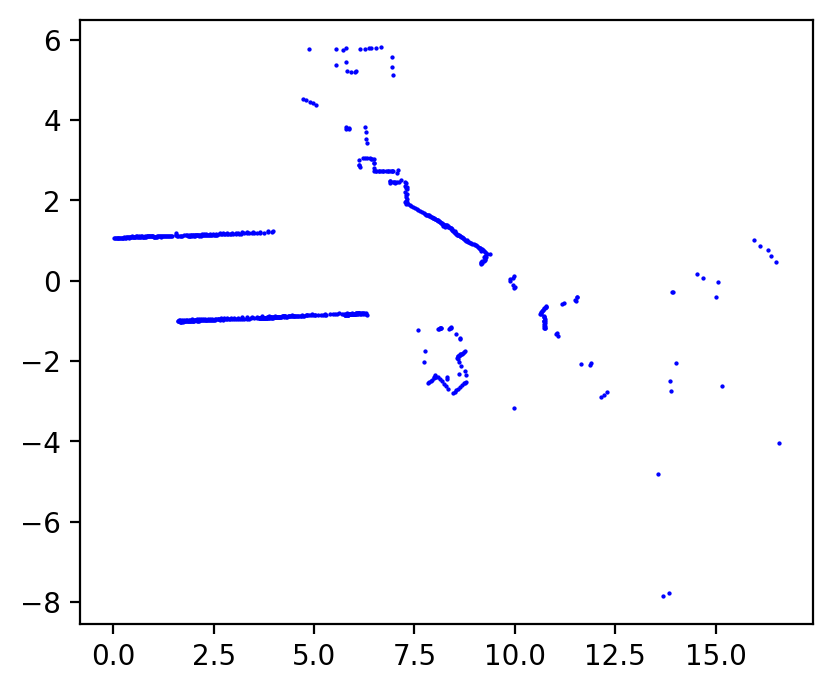

In [4]:
plt.figure(dpi=200)
show_points(laser_data_list[10:20:2], c="blue");

# Build map

In [6]:
map_model_config = MapModelConfig(
    minimal_depth=0.05,
    maximal_depth=10,
    bins_count=60,
    density_scale=0.5,
    variance_weight=0.2,
    F=4,
    L=32,
    T=4096,
    min_log_resolution=-4,
    max_log_resolution=1.,
    huber_delta=0.1
)
learning_config = LearningConfig(
    iterations=100,
    variable_optimizer_config=OptimizerConfig(
        learning_rate=0.5e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=1e-5,
    ),
    hashtable_optimizer_config=OptimizerConfig(
        learning_rate=3e-2,
        beta1=0.9,
        beta2=0.99,
        eps=1e-15,
        weight_decay=0,
    )
)
mlp_model = MLPModel()
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)

learning_index = 17
laser_data = laser_data_list[learning_index]
map_position = jnp.array(laser_data.odometry_position.as_vec())
map_model = map_builder.build_map(laser_data, map_position)

Compilation take 3.475572109222412 s


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 39.95it/s]


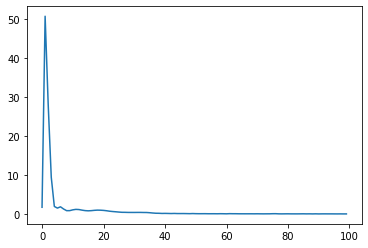

In [7]:
plt.plot(map_builder.loss_history)

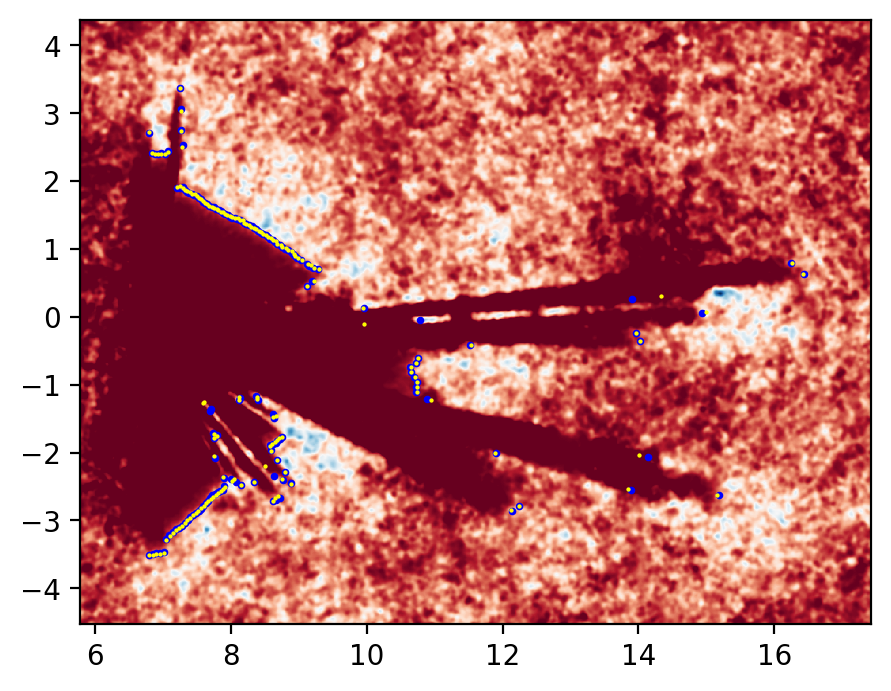

In [8]:
plt.figure(dpi=200)
points = show_points(laser_data_list[learning_index:learning_index + 1])
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), angle=0, 
                   vmin=0, vmax=None)

plot_reconstructed_result(laser_data_list[learning_index], map_model_config, mlp_model, 
                          map_model, s=3)
show_points(laser_data_list[learning_index:learning_index + 1], c="yellow");

# Make local BA SLAM

In [9]:
import jax.random

In [29]:
position_optimization_config = BatchPositionOptimizerConfig(
    iterations=100,
    init_hessian = jnp.diag(jnp.array([20, 20, 300])),
    maximal_clip_norm = 20,
    beta1 = 0,
    beta2 = 0,
    hessian_adder = jnp.diag(jnp.array([0, 0, 0])),
    batch_size = 5,
    learning_rate=0.9,
)

In [30]:
def init_positions(data_list, noise=0):
    result = jnp.array([x.odometry_position.as_vec() for x in data_list]).reshape(-1)
    delta = jax.random.normal(jax.random.PRNGKey(0), result.shape) * noise
    delta = jnp.concatenate([jnp.zeros(3), delta[3:]], axis=0)
    return result + delta


In [56]:
iterations = 100
batch_size = 5
np.random.seed(200)
position_optimization_config.batch_size = batch_size
local_data_list = laser_data_list[10:15:1]
# local_data_list = laser_data_list[40:50:2]
optimized_positions = init_positions(local_data_list)
map_model = init_map_model(mlp_model, map_model_config)

scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
map_builder = MapBuilder(learning_config, map_model_config, mlp_model)
mapping_positions = optimized_positions.reshape(-1, 3)[scan_data_batch.indices]
map_builder.setup(scan_data_batch.scan_data, map_model, mapping_positions)

position_optimizer = BatchPositionOptimizer(position_optimization_config, map_model_config, mlp_model)
position_optimizer.setup()

postion_optimizer_states = []
for i in tqdm.tqdm(range(iterations)):
    np.random.seed(200)
#     if i <= 30:
    scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
#     print(scan_data_batch.scan_data.depths)
    mapping_positions = optimized_positions.reshape(-1, 3)[scan_data_batch.indices]
    new_map_model = map_builder.step(map_model, mapping_positions, scan_data_batch.scan_data)
    if i > 30:
#         position_optimizer.state.iteration = 0
        preivous_optimized_positions = optimized_positions
        optimized_positions = position_optimizer.step(optimized_positions, map_model, scan_data_batch)
#         optimized_positions = jnp.concatenate([preivous_optimized_positions[:3], optimized_positions[3:]], axis=0)
    postion_optimizer_states.append(position_optimizer.state)
    map_model = new_map_model
reconstructed_positions = [Position2D.from_vec(np.array(x)) for x in optimized_positions.reshape(-1, 3)]

Compilation take 2.8527414798736572 s


100%|█████████████████████████████████████████| 100/100 [00:11<00:00,  8.77it/s]


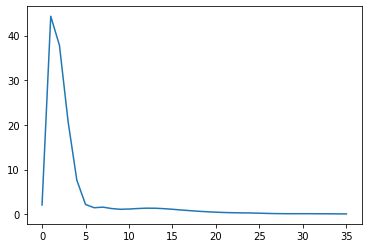

In [57]:
plt.plot(map_builder.loss_history)

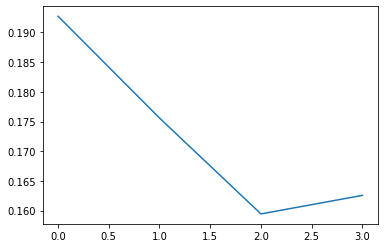

In [58]:
plt.plot(position_optimizer.loss_history)

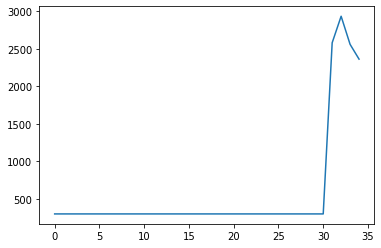

In [59]:
data = [x.previous_hessian[2, 2] for x in postion_optimizer_states]
plt.plot(data)

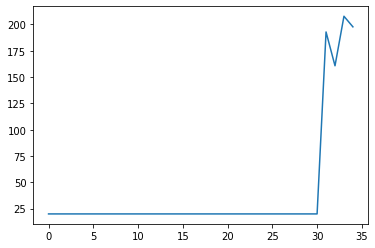

In [60]:
data = [x.previous_hessian[3, 3] for x in postion_optimizer_states]
plt.plot(data)

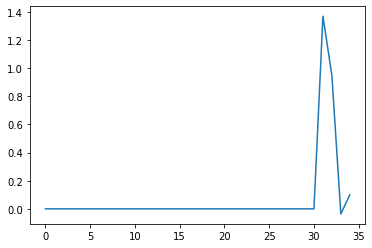

In [61]:
data = [x.previous_grad[1] for x in postion_optimizer_states]
plt.plot(data)

In [62]:
postion_optimizer_states[5].previous_grad.shape

(15,)

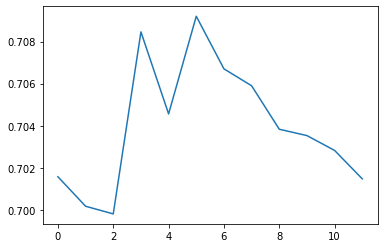

In [52]:
data = [x.x for x in position_optimizer.position_history]
plt.plot(data)

In [53]:
def get_points_from_laser_data_list(data_list):
    all_points = []
    for laser_data in data_list:
        all_points.append(laser_data.as_points_in_odometry_frame())
    points = np.concatenate(all_points, axis=0)
    return points

def plot_scans_at_positions(data_list, positions, c="green"):
    all_points = []
    for position, laser_data in zip(positions, data_list):
        all_points.append(position.apply(laser_data.as_points()))
    points = np.concatenate(all_points, axis=0)
    plt.scatter(points[:, 0], points[:, 1], s=0.5, c=c)
    return points

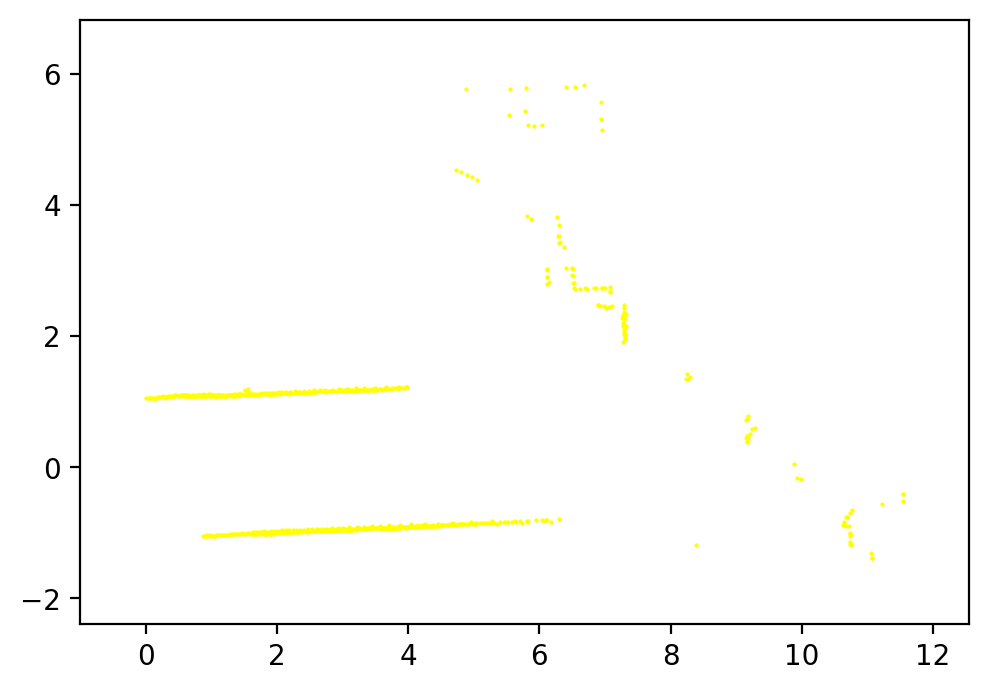

In [55]:
plt.figure(dpi=200)
points = get_points_from_laser_data_list(local_data_list)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model, bounds, mlp_model, grid_shape=(1000, 1000), 
                   vmin=None, vmax=None)
index=3
plot_reconstructed_result(local_data_list[index], map_model_config, mlp_model, 
                          map_model, s=3, position=reconstructed_positions[index])
plot_scans_at_positions(local_data_list, reconstructed_positions, c="black");
show_points(local_data_list, c="yellow");

# Use two position sets

In [30]:
# class NFLocalSlam:
#     def __init__(self, self._batch_size, position_optimization_config, local_data_list, ):
#         batch_size = 5
#         position_optimization_config.batch_size = batch_size
#         local_data_list = laser_data_list[10:20:2]
#         # local_data_list = laser_data_list[40:50:2]
#         self._optimized_positions = init_positions(local_data_list)
#         map_model = init_map_model(mlp_model, map_model_config)

#         scan_data_batch = ScanDataBatch.from_data_list(local_data_list, 100)
#         map_builder = MapBuilder(learning_config, map_model_config, mlp_model)
#         mapping_positions = optimized_positions.reshape(-1, 3)[scan_data_batch.indices]
#         map_builder.setup(scan_data_batch.scan_data, map_model, mapping_positions)

#         position_optimizer = BatchPositionOptimizer(position_optimization_config, map_model_config, mlp_model)
#         position_optimizer.setup()

#         postion_optimizer_states = []
    
#     def mapping_step():
    
#     def tracking_step():
#         pass
    

In [31]:
position_optimization_config = BatchPositionOptimizerConfig(
    iterations=100,
    init_hessian = jnp.diag(jnp.array([200, 200, 20])),
    maximal_clip_norm = 50,
    beta1 = 0.9,
    beta2 = 0.1,
    hessian_adder = jnp.diag(jnp.array([10, 10, 10])),
    batch_size = 5,
    learning_rate=0.9,
)

In [32]:
iterations = 300
batch_size = 5
position_optimization_config.batch_size = batch_size
local_data_list1 = laser_data_list[10:20:2]
local_data_list2 = laser_data_list[11:21:2]
# local_data_list = laser_data_list[40:50:2]
optimized_positions1 = init_positions(local_data_list1)
optimized_positions2 = init_positions(local_data_list2)
map_model1 = init_map_model(mlp_model, map_model_config)
map_model2 = init_map_model(mlp_model, map_model_config)

scan_data_batch1 = ScanDataBatch.from_data_list(local_data_list1, 100)
scan_data_batch2 = ScanDataBatch.from_data_list(local_data_list2, 100)
map_builder1 = MapBuilder(learning_config, map_model_config, mlp_model)
map_builder2 = MapBuilder(learning_config, map_model_config, mlp_model)
mapping_positions1 = optimized_positions1.reshape(-1, 3)[scan_data_batch1.indices]
mapping_positions2 = optimized_positions2.reshape(-1, 3)[scan_data_batch2.indices]
map_builder1.setup(scan_data_batch1.scan_data, map_model1, mapping_positions1)
map_builder2.setup(scan_data_batch2.scan_data, map_model2, mapping_positions2)

position_optimizer1 = BatchPositionOptimizer(position_optimization_config, map_model_config, mlp_model)
position_optimizer1.setup()


position_optimizer2 = BatchPositionOptimizer(position_optimization_config, map_model_config, mlp_model)
position_optimizer2.setup()

postion_optimizer_states = []
for i in tqdm.tqdm(range(iterations)):
    scan_data_batch = ScanDataBatch.from_data_list(local_data_list1, 100)
    mapping_positions1 = optimized_positions1.reshape(-1, 3)[scan_data_batch.indices]
    map_model1 = map_builder1.step(map_model1, mapping_positions1, scan_data_batch.scan_data)
    
    scan_data_batch = ScanDataBatch.from_data_list(local_data_list2, 100)
    mapping_positions2 = optimized_positions2.reshape(-1, 3)[scan_data_batch.indices]
    map_model2 = map_builder2.step(map_model2, mapping_positions2, scan_data_batch.scan_data)
    if i > 100:
        scan_data_batch = ScanDataBatch.from_data_list(local_data_list1, 100)
        preivous_optimized_positions = optimized_positions1
        optimized_positions1 = position_optimizer1.step(optimized_positions1, map_model2, scan_data_batch)
#         optimized_positions1 = jnp.concatenate([preivous_optimized_positions[:3], optimized_positions1[3:]], axis=0)
        
        scan_data_batch = ScanDataBatch.from_data_list(local_data_list2, 100)
        optimized_positions2 = position_optimizer2.step(optimized_positions2, map_model1, scan_data_batch)
    postion_optimizer_states.append(position_optimizer.state)


Compilation take 2.587167501449585 s
Compilation take 2.66703724861145 s


100%|█████████████████████████████████████████| 300/300 [01:00<00:00,  5.00it/s]


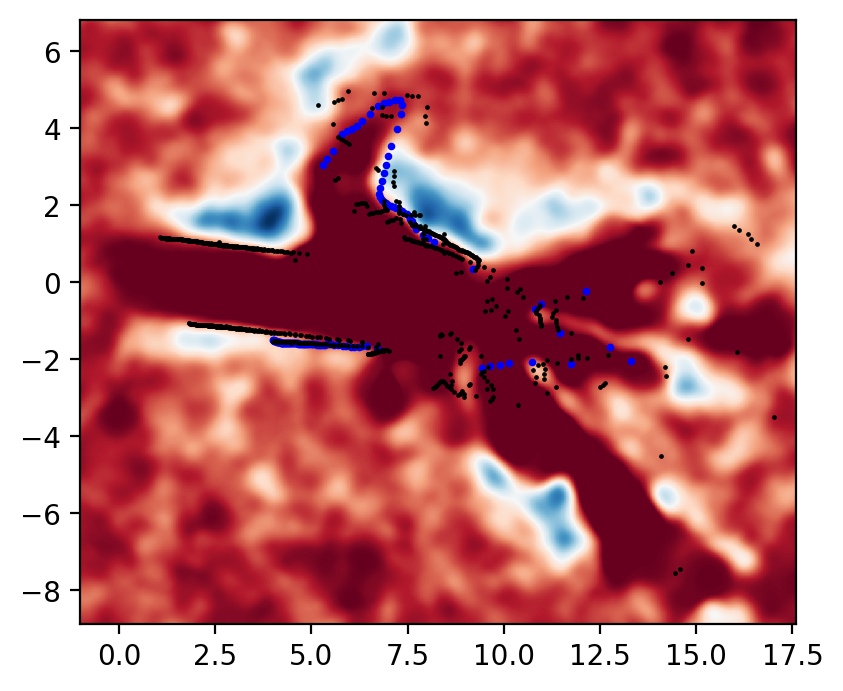

In [33]:
plt.figure(dpi=200)
reconstructed_positions = [Position2D.from_vec(np.array(x)) for x in optimized_positions1.reshape(-1, 3)]
points = get_points_from_laser_data_list(local_data_list1)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model2, bounds, mlp_model, grid_shape=(1000, 1000), 
                   vmin=0, vmax=None)
index=2
plot_reconstructed_result(local_data_list1[index], map_model_config, mlp_model, 
                          map_model1, s=3, position=reconstructed_positions[index])
plot_scans_at_positions(local_data_list1, reconstructed_positions, c="black");
# show_points(local_data_list, c="yellow");

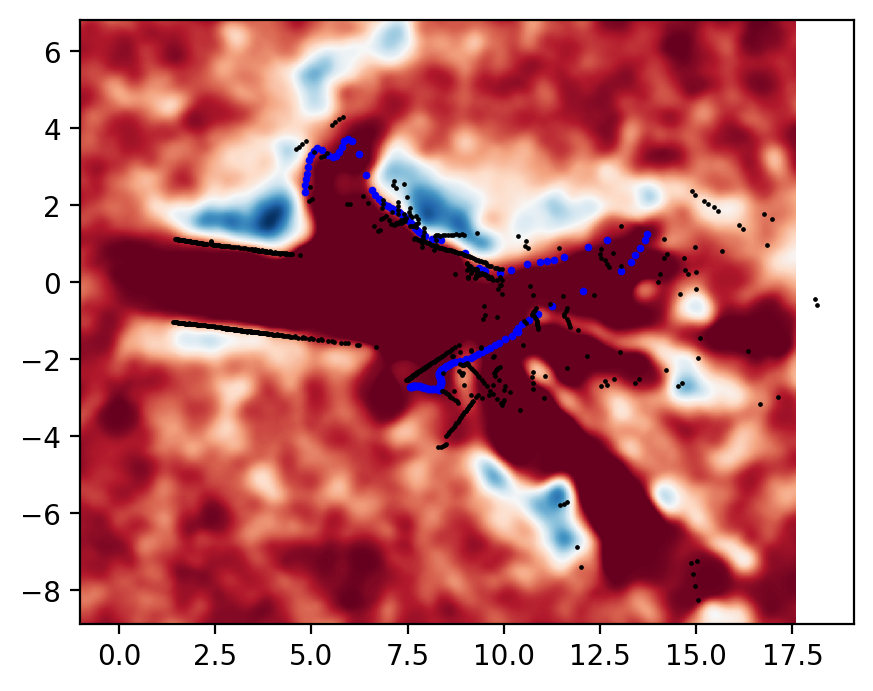

In [34]:
plt.figure(dpi=200)
reconstructed_positions = [Position2D.from_vec(np.array(x)) for x in optimized_positions2.reshape(-1, 3)]
points = get_points_from_laser_data_list(local_data_list1)
bounds = (np.min(points[:, 0]) - 1, np.max(points[:, 0]) + 1, np.min(points[:, 1]) - 1, np.max(points[:, 1]) + 1)
plot_model_heatmap(map_model2, bounds, mlp_model, grid_shape=(1000, 1000), 
                   vmin=0, vmax=None)
index=2
plot_reconstructed_result(local_data_list1[index], map_model_config, mlp_model, 
                          map_model2, s=3, position=reconstructed_positions[index])
plot_scans_at_positions(local_data_list2, reconstructed_positions, c="black");
# show_points(local_data_list, c="yellow");